In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/DDU+CE"

/content/drive/MyDrive/DDU+CE


In [ ]:
!pip install ddu_dirty_mnist

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sb


from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import EMNIST, FashionMNIST, MNIST
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
from metrics.AGAN import get_noise, Generator, Discriminator
from DDU.train_utils import get_data


# dataloaders

In [ ]:
batch_size = 100
device = 'cuda'


em_loader = DataLoader(EMNIST("./data", split='letters', train=False, download=False, transform=transforms.ToTensor()), 
                        batch_size, shuffle = True)
fashion_loader = DataLoader(FashionMNIST("./data", train=False, download=False, transform=transforms.ToTensor()), 
                        batch_size, shuffle = True)
_, _, mnist_loader = get_data('./data')

In [ ]:
# nice plot with code taken from https://github.com/omegafragger/DDU/blob/main/notebooks/fig_1_plot.ipynb

def plot_density(data1, data2, binrange, separate_ID=False, xlabel='NLL'):
    clrs = ['#1f77b4','#ff7f0e', '#2ca02c','#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22','#17becf']
    sb.set_style('whitegrid')

    plt.figure(figsize=(5,3))
    plt.tight_layout()

    range = dict(bins=30, binrange=binrange, element="step", fill=True, alpha=0.7)
    kw_separate_id = dict(hue="category", multiple="stack",
                hue_order=[1, 0],
                palette=[sb.color_palette()[4], sb.color_palette()[0]]) if separate_ID else dict(color=sb.color_palette()[0])

    sb.histplot(data1, color=sb.color_palette()[0],
                stat='probability', kde=False, **range, label="dummy", legend=False) # 'Dirty-MNIST (In-distribution)')
    sb.histplot(data2, color=sb.color_palette()[1],
                stat='probability', kde=False, **range, label="dummy", legend=False) #, label='Fashion-MNIST (OoD)')


    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Fraction', fontsize=12)

# AnoGAN


In [ ]:
num_steps = 380
name = 'WGAN41m'

gen = Generator().to(device) 
disc = Discriminator().to(device) 
gen.load_state_dict(torch.load(f'./metrics/{name}_gen_{num_steps}.pt', map_location=device))
disc.load_state_dict(torch.load(f'./metrics/{name}_disc_{num_steps}.pt', map_location=device))
gen.eval()
disc.eval()

Discriminator(
  (disc1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  )
  (disc2): Sequential(
    (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 1, kernel_size=(5, 5), stride=(2, 2), bias=False)
  )
)

In [ ]:
def calc_AGAN(images, steps=4000, lam=.1, step_size=0.03, mom = .0, rep=3):
    
    im_features = disc.feature(images.view(len(images),1,28,28))
    loss_min = torch.ones(len(images),) * float('inf')
    stepsize = step_size
    for i in range(rep):
        z = get_noise(len(images), 64, device=images.device)
        z_grad = torch.zeros_like(z).to(images.device)
        for i in range(steps):
            z.requires_grad = True
            z.grad = None
            disc.zero_grad()
            gen.zero_grad()
            assert z.grad is None
            new_images = gen(z)
            res_loss = torch.abs(images - new_images).sum((1,2,3))
            disc_loss = torch.abs(im_features - disc.feature(new_images)).sum((1,2,3))
            loss = res_loss + disc_loss * lam
            loss_reduced = loss.sum()
            loss_reduced.backward(retain_graph=True)
            z.requires_grad = False
            #z_grad = z.grad.clone()
            z -= (z.grad + mom*z_grad) * stepsize
            z_grad = z.grad

            if i == steps - (steps // 5):
                stepsize /= 10
        loss_min = torch.min(loss_min, loss.detach().cpu())
        
    return loss_min.numpy()

### MNIST

In [ ]:
AnoGANsM = []
for X_batch, _ in tqdm(mnist_loader):
    X_batch = X_batch.to(device)
    agans = calc_AGAN(X_batch)
    AnoGANsM += agans.tolist()
torch.save(torch.tensor(AnoGANsM), './metrics/AGANs_MNIST.pt')


  0%|          | 0/79 [00:00<?, ?it/s]

### EMNIST

In [ ]:
AnoGANsEM = []
for X_batch, _ in tqdm(em_loader):
    X_batch = X_batch.to(device)
    agans = calc_AGAN(X_batch)
    AnoGANsEM += agans.tolist()
torch.save(torch.tensor(AnoGANsEM), './metrics/AGANs_EMNIST.pt')

  0%|          | 0/208 [00:00<?, ?it/s]

### Fashion-MNIST

In [ ]:
AnoGANsFM = []
for X_batch, _ in tqdm(fashion_loader):
    X_batch = X_batch.to(device)
    agans = calc_AGAN(X_batch)
    AnoGANsFM += agans.tolist()
torch.save(torch.tensor(AnoGANsFM), './metrics/AGANs_FMNIST.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

### compare MNIST vs EMNIST

In [ ]:
AnoGANsEM = torch.load('./metrics/AGANs_EMNIST.pt').tolist()
AnoGANsM = torch.load('./metrics/AGANs_MNIST.pt').tolist()

0.913451704326923


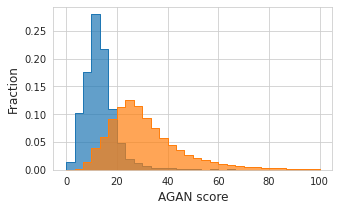

In [ ]:
plot_density(AnoGANsM, AnoGANsEM, binrange=[0, 100], separate_ID=True, xlabel='AGAN score')

zeros = torch.zeros((len(AnoGANsM,)))
ones = torch.ones((len(AnoGANsEM,)))
labels = zeros.tolist() + ones.tolist()

AUROC = roc_auc_score(labels, AnoGANsM + AnoGANsEM)
print(AUROC) # 0.915

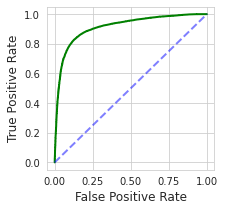

In [ ]:
fpr, tpr, thresholds = roc_curve(labels, AnoGANsM + AnoGANsEM)

plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, color='green', lw=2)
plt.plot([0, 1], [0, 1], color='blue', lw=2, alpha=.5, linestyle='--')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.show()

### compare MNIST vs FashionMNIST

In [ ]:
AnoGANsFM = torch.load('./metrics/AGANs_FMNIST.pt').tolist()
AnoGANsM = torch.load('./metrics/AGANs_MNIST.pt').tolist()

0.9978284000000001


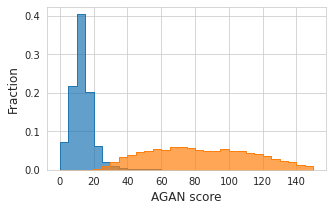

In [ ]:
plot_density(AnoGANsM, AnoGANsFM, binrange=[0, 150], separate_ID=True, xlabel='AGAN score')

zeros = torch.zeros((len(AnoGANsM,)))
ones = torch.ones((len(AnoGANsFM,)))
labels = zeros.tolist() + ones.tolist()

AUROC = roc_auc_score(labels, AnoGANsM + AnoGANsFM)
print(AUROC) # 0.9

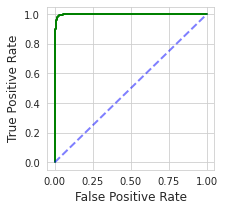

In [ ]:
fpr, tpr, thresholds = roc_curve(labels, AnoGANsM + AnoGANsFM)

plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, color='green', lw=2)
plt.plot([0, 1], [0, 1], color='blue', lw=2, alpha=.5, linestyle='--')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.show()